In [1]:
%load_ext autoreload
%autoreload 2

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Project Goals & Overview:
Develop and train a natural language processing model to classify the sentiment of tweets.

## Business Understanding:
Companies can benefit from understanding how consumers perceive and feel about their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner.

## Data Understanding:
The data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions). From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th).

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys, string, re, itertools, more_itertools, random
from more_itertools import take

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.base import clone
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (StratifiedKFold, train_test_split,
                                     cross_val_score, GridSearchCV)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer,
                                             TfidfTransformer)
from sklearn.metrics import (f1_score, recall_score, precision_score,
                             make_scorer, plot_confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

import matplotlib.pyplot as plt
# from matplotlib import cm
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

from src import visualizations as vz
from src import functions as fn
from src import classes as cl                                     

# # updates for nltk helper packages if needed
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
                                     
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## Modeling I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = path = os.path.join(gparent, 'data/processed',\
                           'modeling_binary.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,1,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['#RISE_Austin', '#SXSW']"
1,0,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,['#SXSW']
2,0,wait ipad also sale,wait ipad also sale,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['#iPad', '#SXSW']"
3,1,hope year festiv crashi year iphon app,hope year festival crashy year iphone app,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,['#sxsw']
4,0,great stuff fri marissa mayer googl tim reilli...,great stuff fri marissa mayer google tim reill...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,['#SXSW']


## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        3537 non-null   int64 
 1   stems          3537 non-null   object
 2   lemmas         3537 non-null   object
 3   tweet          3537 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3531 non-null   object
dtypes: int64(1), object(5)
memory usage: 165.9+ KB


## Splitting Initial `data` & `target` Series
<font size="4">`emotion` column values = {1: 'negative', 0: 'positive'}</font>

In [6]:
data_lemms = df.lemmas
data_stems = df.stems
target = df['emotion']

In [7]:
data_lemms.isna().sum()
data_stems.isna().sum()

0

In [8]:
target.isna().sum()

0

In [9]:
# checking lengths
idx = [data_lemms, data_stems, target]
for i in idx:
    print(f'{len(i)}')

3537
3537
3537


## Creating Modeling & Holdout Data

We are going to focus on modeling with the lemmatized, but we'll prepare a train-validation-test split for the stemmed data just in case. 

In [10]:
# Creating data & target
X_lem = data_lemms
y_lem = target

In [11]:
# checking lengths
print(len(X_lem))
print(len(y_lem))

3537
3537


<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [12]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = fn.splitter(X_lem, y_lem)

In [13]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

2652
2652
885
885


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [14]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = fn.splitter(X_lem_training, y_lem_training)

In [15]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

1989
1989
663
663


#### Stemmed Data

In [16]:
X_stem = data_stems
y_stem = target

In [17]:
# checking lengths
print(len(X_stem))
print(len(y_stem))

3537
3537


<font size="4"> Creating holdout data for testing. X_stem_testing and y_stem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original stemmed data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [18]:
X_stem_training, X_stem_testing, y_stem_training, y_stem_testing = fn.splitter(X_stem, y_stem)

In [19]:
# checking sizes
print(len(X_stem_training))
print(len(y_stem_training))
print(len(X_stem_testing))
print(len(y_stem_testing))

2652
2652
885
885


<font size="4">Splitting the X_stem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_stem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [20]:
X_stem_train, X_stem_val, y_stem_train, y_stem_val = fn.splitter(X_stem_training, y_stem_training)

In [21]:
# checking sizes
print(len(X_stem_train))
print(len(y_stem_train))
print(len(X_stem_val))
print(len(y_stem_val))

1989
1989
663
663


In [22]:
len(X_stem) == len(y_stem)

True

## EDA & Corpus Statistics 

## Splitting Emotions

In [23]:
positive = df[df['emotion']==0]
negative = df[df['emotion']==1]

## Emotion Vocabularies

#### Lemma Vocabulary

In [24]:
vocab_lem_pos = fn.vocabulary(positive.lemmas)
len(vocab_lem_pos)

4632

<font size="4"> There are 4,624 unique tokens in the positve lemmatized tweets.</font>

In [25]:
pos_words = fn.words(positive.lemmas)
fn.word_frequencies(pos_words, 25)

Word 			Frequency

ipad      		0.0358    
apple     		0.0326    
google    		0.0257    
store     		0.0196    
iphone    		0.0192    
app       		0.014     
new       		0.0126    
austin    		0.0103    
pop       		0.0075    
ipad2     		0.0073    
android   		0.0072    
get       		0.0063    
launch    		0.0061    
party     		0.0053    
one       		0.0053    
line      		0.0051    
great     		0.0048    
time      		0.0048    
via       		0.0046    
day       		0.0044    
free      		0.0043    
social    		0.0043    
circle    		0.0043    
win       		0.0043    
cool      		0.0042    


<font size="4">Fill</font> 

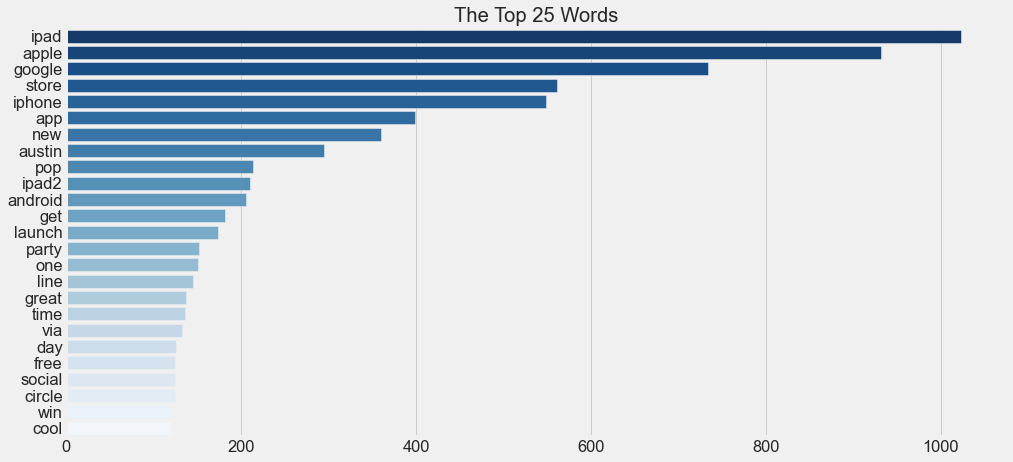

In [26]:
vz.top_word_list(pos_words, 25)

<font size="4">Fill</font>

In [27]:
vocab_lem_neg = fn.vocabulary(negative.lemmas)
len(vocab_lem_neg)

1922

<font size="4"> There are 1,920 unique tokens in the negative lemmatized tweets.</font>

In [28]:
neg_words = fn.words(negative.lemmas)
fn.word_frequencies(neg_words, 25)

Word 			Frequency

ipad      		0.0343    
iphone    		0.0285    
google    		0.0266    
apple     		0.0216    
app       		0.0106    
store     		0.0083    
new       		0.0076    
like      		0.0076    
circle    		0.0065    
need      		0.0062    
social    		0.0055    
apps      		0.0053    
design    		0.0051    
people    		0.0051    
austin    		0.0049    
get       		0.0044    
android   		0.0042    
one       		0.004     
think     		0.004     
time      		0.004     
line      		0.0039    
launch    		0.0039    
day       		0.0039    
today     		0.0037    
look      		0.0037    


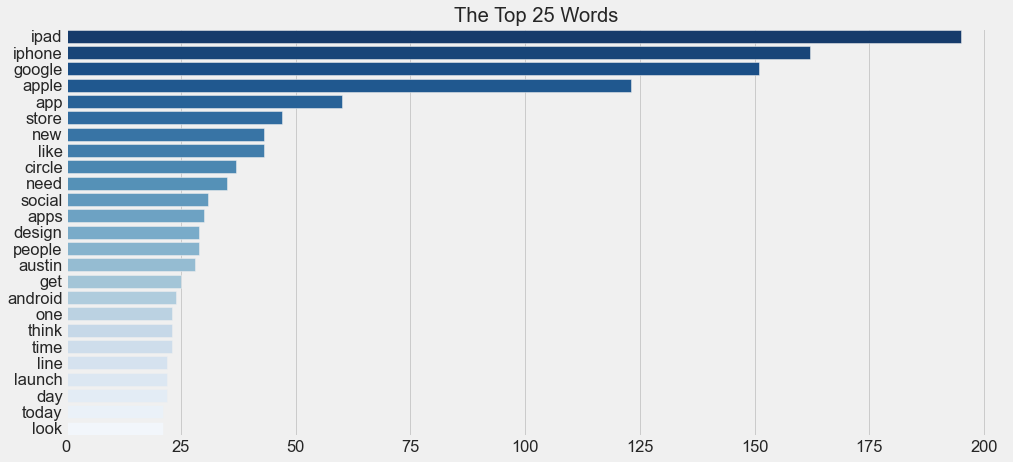

In [29]:
vz.top_word_list(neg_words, 25)

<font size="4">FILL.</font> 

## Word Clouds

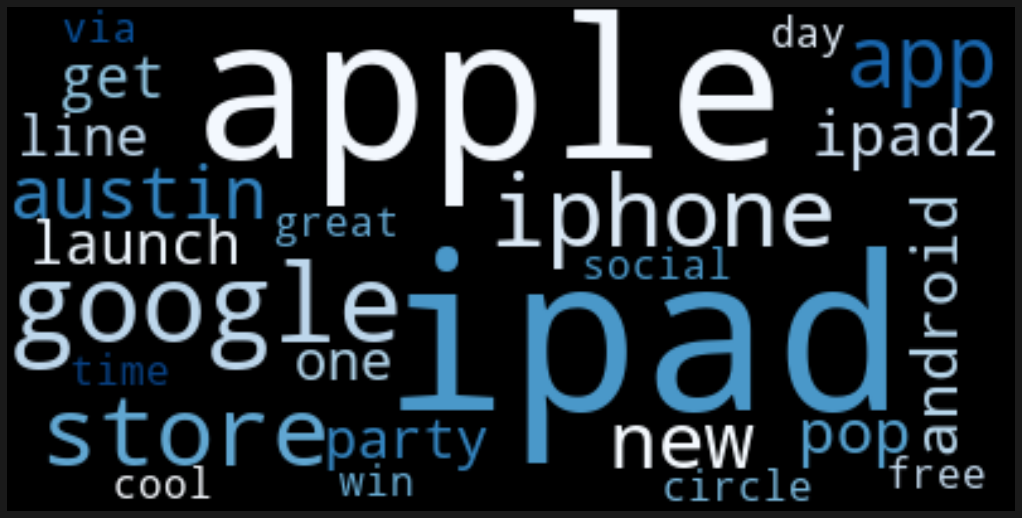

In [30]:
vz.word_cloud(pos_words, 25)

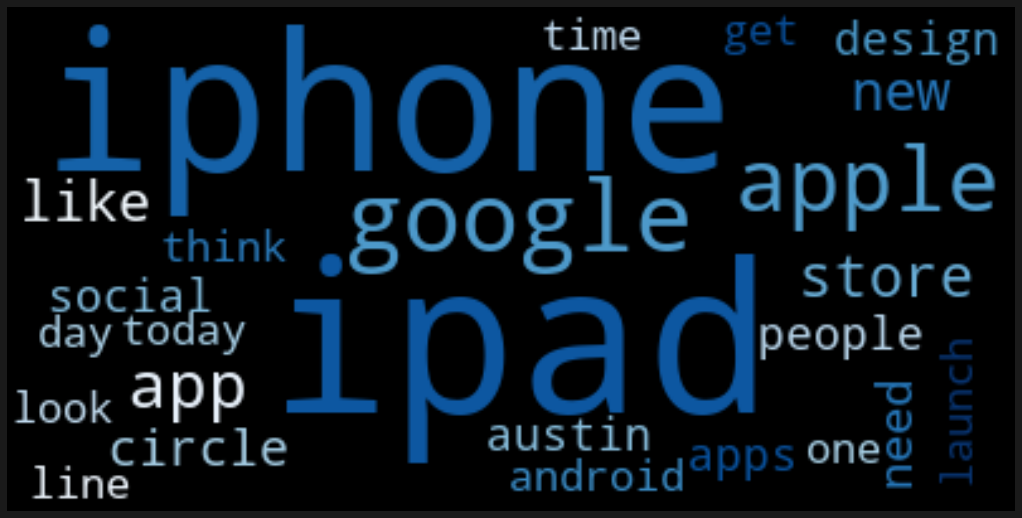

In [31]:
vz.word_cloud(neg_words, 25)

## Modeling Objects

In [32]:
# creating f1 scorer
f1 = fn.f1

# creating Harness
modeling = cl.Harness(f1)

# creating tfidf instance
tfidf = TfidfVectorizer(ngram_range=(1,1))

# creating oversampler instance
oversample = RandomOverSampler(sampling_strategy='minority', random_state=2021)

# creating SMOTE instance
sm = SMOTE(random_state=2021)

## Creating a Basline Classifier

In [33]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [34]:
steps = [('tfidf', tfidf), ('clf', LR)]
baseline = Pipeline(steps=steps)

In [35]:
baseline.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [36]:
modeling.report(baseline, X_lem_train, y_lem_train, 'LR baseline', 'tfidf/no ngrams, no sampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR baseline has an average F1 of 0.06497737556561087


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


array([0.        , 0.08823529, 0.11764706, 0.03076923, 0.08823529])

In [37]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"


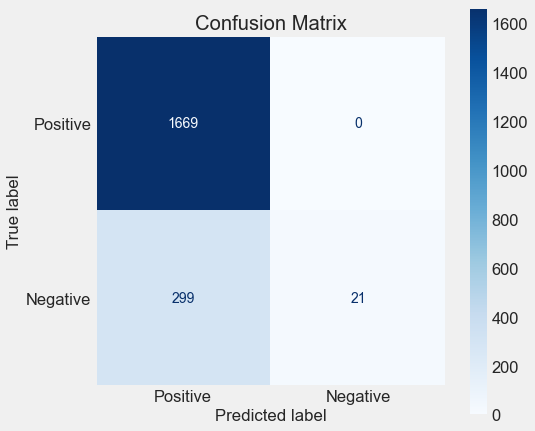

,F1,Recall,Precision
0,0.123167,0.065625,1.0


In [38]:
fn.confusion_report(baseline, X_lem_train, y_lem_train)

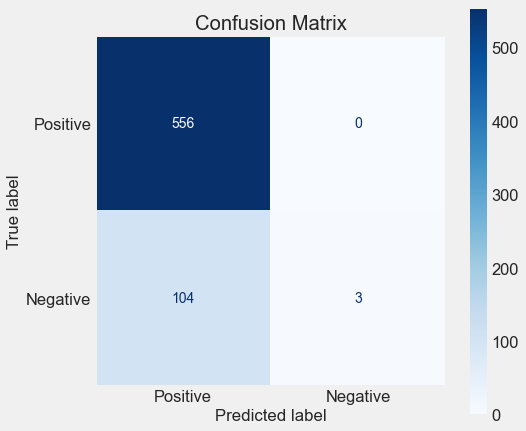

,F1,Recall,Precision
0,0.054545,0.028037,1.0


In [39]:
fn.confusion_report(baseline, X_lem_val, y_lem_val)

## Baseline Minority Oversampling

In [40]:
df.emotion.value_counts(normalize=True)

0    0.839129
1    0.160871
Name: emotion, dtype: float64

In [41]:
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', LR)]
baseline_mo = Pipeline(steps=steps)

In [42]:
baseline_mo.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [43]:
modeling.report(baseline_mo, X_lem_train, y_lem_train, 'baseline_mo', 'minority oversampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


baseline_mo has an average F1 of 0.4796408572270641


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.48275862, 0.51666667, 0.44615385, 0.46031746, 0.49230769])

In [44]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,baseline_mo,0.479641,minority oversampling


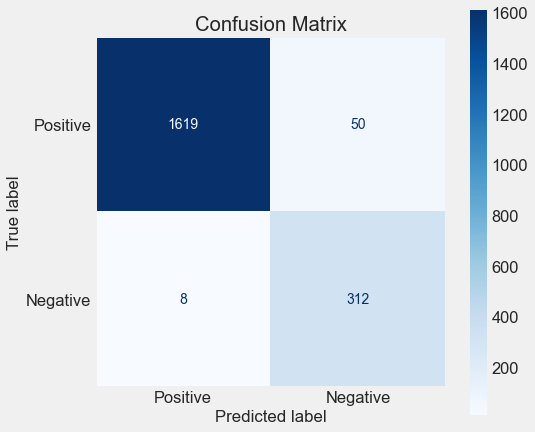

,F1,Recall,Precision
0,0.914956,0.975,0.861878


In [45]:
fn.confusion_report(baseline_mo, X_lem_train, y_lem_train)

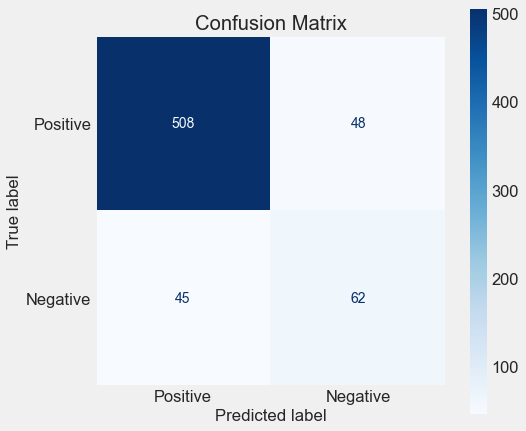

,F1,Recall,Precision
0,0.571429,0.579439,0.563636


In [46]:
fn.confusion_report(baseline_mo, X_lem_val, y_lem_val)

## Baseline Minority Oversampling GridSearch

In [47]:
tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [48]:
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [49]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }

In [50]:
# grid_clf_f1 = GridSearchCV(baseline_mo, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf_f1.fit(X_lem_train, y_lem_train)

In [51]:
# print('Best ngram_range:', grid_clf_f1.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf_f1.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['clf__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['clf__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['clf__solver'])

In [52]:
# steps = grid_clf_f1.best_estimator_.get_params()['steps']

In [53]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf',
  LogisticRegression(C=1.2742749857031321, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [54]:
tuned_baseline_mo = Pipeline(steps=saved_steps)
tuned_baseline_mo.fit(X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(C=1.2742749857031321, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [55]:
modeling.report(tuned_baseline_mo, X_lem_train, y_lem_train, 'tuned_baseline_mo', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_baseline_mo has an average F1 of 0.4773430491127499


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.45614035, 0.5210084 , 0.453125  , 0.46031746, 0.49612403])

In [56]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
2,tuned_baseline_mo,0.477343,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
1,baseline_mo,0.479641,minority oversampling


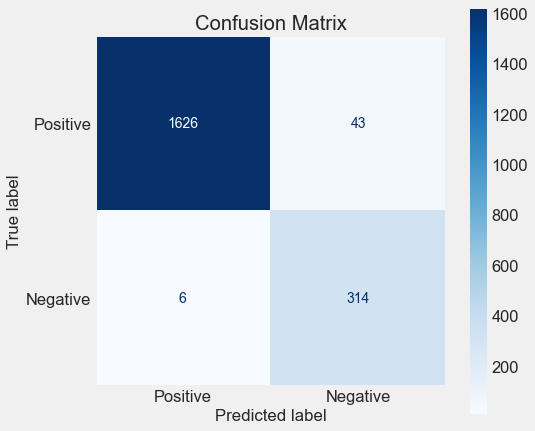

,F1,Recall,Precision
0,0.927622,0.98125,0.879552


In [57]:
fn.confusion_report(tuned_baseline_mo, X_lem_train, y_lem_train)

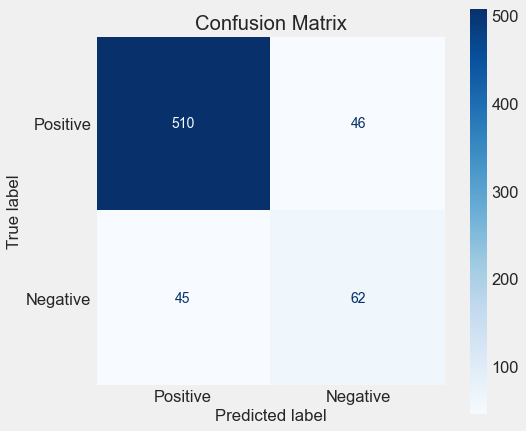

,F1,Recall,Precision
0,0.576744,0.579439,0.574074


In [58]:
fn.confusion_report(tuned_baseline_mo, X_lem_val, y_lem_val)

## Baseline SMOTE 

In [59]:
steps = [('tfidf', tfidf), ('oversample', sm), ('clf', LR)]
baseline_smote = Pipeline(steps=steps)

In [60]:
baseline_smote.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [61]:
modeling.report(baseline_smote, X_lem_train, y_lem_train, 'baseline smote', 'smote')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


baseline smote has an average F1 of 0.4546016133652224


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.45045045, 0.54098361, 0.41221374, 0.41481481, 0.45454545])

In [62]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
3,baseline smote,0.454602,smote
1,tuned_baseline_mo,0.477343,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
2,baseline_mo,0.479641,minority oversampling


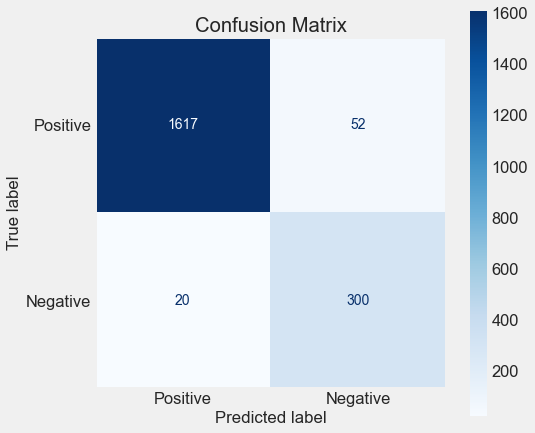

,F1,Recall,Precision
0,0.892857,0.9375,0.852273


In [63]:
fn.confusion_report(baseline_smote, X_lem_train, y_lem_train)

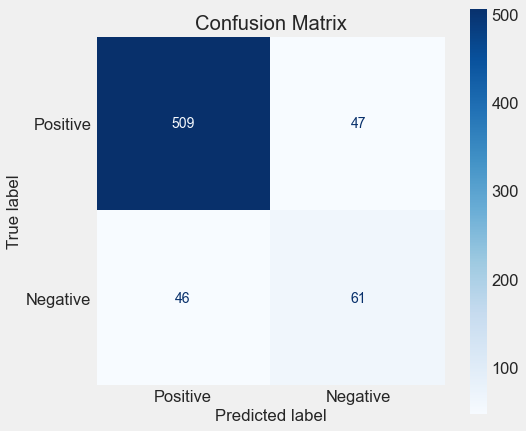

,F1,Recall,Precision
0,0.567442,0.570093,0.564815


In [64]:
fn.confusion_report(baseline_smote, X_lem_val, y_lem_val)

## Baseline SMOTE GridSearch

In [65]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }


In [66]:
# grid_clf = GridSearchCV(baseline_smote, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [67]:
# print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best C:', grid_clf.best_estimator_.get_params()['clf__C'])
# print('Best penalty:', grid_clf.best_estimator_.get_params()['clf__penalty'])
# print('Best solver:', grid_clf.best_estimator_.get_params()['clf__solver'])

In [68]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [69]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample', SMOTE(random_state=2021)),
 ('clf',
  LogisticRegression(C=5.455594781168514, max_iter=1000, n_jobs=-1,
                     random_state=2021, solver='liblinear', verbose=2))]

In [70]:
tuned_baseline_smote = Pipeline(steps=saved_steps)
tuned_baseline_smote.fit( X_lem_train, y_lem_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(C=5.455594781168514, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

In [71]:
modeling.report(tuned_baseline_smote, X_lem_train, y_lem_train, 'tuned_baseline_smote', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_baseline_smote has an average F1 of 0.45861236949105655


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.42990654, 0.5       , 0.42735043, 0.448     , 0.48780488])

In [72]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,baseline smote,0.454602,smote
4,tuned_baseline_smote,0.458612,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
2,tuned_baseline_mo,0.477343,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,baseline_mo,0.479641,minority oversampling


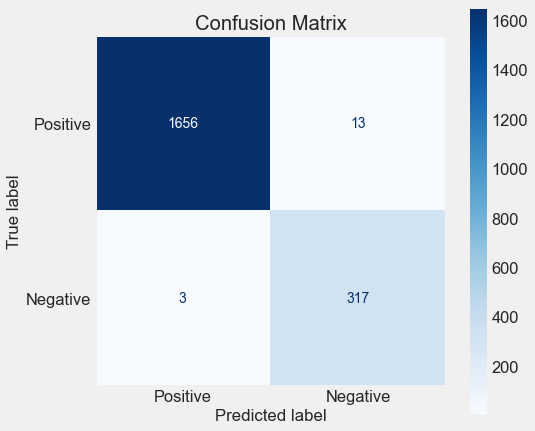

,F1,Recall,Precision
0,0.975385,0.990625,0.960606


In [73]:
fn.confusion_report(tuned_baseline_smote, X_lem_train, y_lem_train)

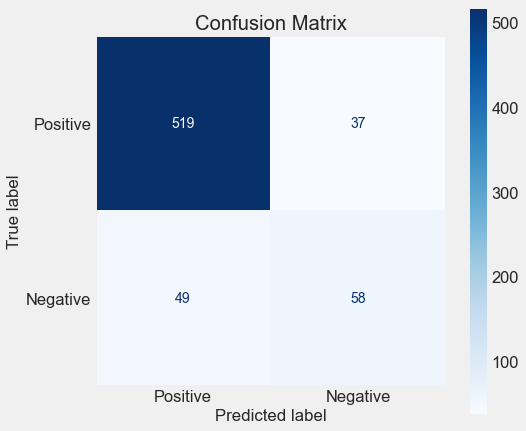

,F1,Recall,Precision
0,0.574257,0.542056,0.610526


In [74]:
fn.confusion_report(tuned_baseline_smote, X_lem_val, y_lem_val)

## Naive Bayes

In [75]:
bayes = MultinomialNB()
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', bayes)]
mnb = Pipeline(steps=steps)
mnb.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB())])

In [76]:
modeling.report(mnb, X_lem_train, y_lem_train, 'multibayes', 'minority oversamp')

multibayes has an average F1 of 0.48731121474503925


array([0.47887324, 0.49635036, 0.47435897, 0.47741935, 0.50955414])

In [77]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,baseline smote,0.454602,smote
2,tuned_baseline_smote,0.458612,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.477343,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,baseline_mo,0.479641,minority oversampling
5,multibayes,0.487311,minority oversamp


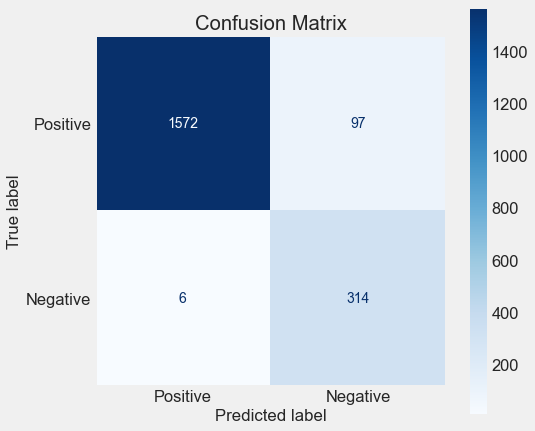

,F1,Recall,Precision
0,0.859097,0.98125,0.76399


In [78]:
fn.confusion_report(mnb, X_lem_train, y_lem_train)

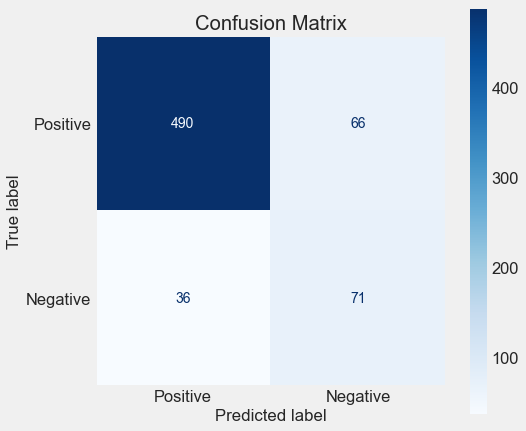

,F1,Recall,Precision
0,0.581967,0.663551,0.518248


In [79]:
fn.confusion_report(mnb, X_lem_val, y_lem_val)

## Tuned Naive Bayes

In [80]:
bayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [81]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0, 25, .5, .75, 1],
    'clf__class_prior': [None, [.16, .84]],
    'clf__fit_prior': [True, False]
    }


In [82]:
# grid_clf = GridSearchCV(mnb, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [83]:
# print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best clf__alpha:', grid_clf.best_estimator_.get_params()['clf__alpha'])
# print('Best clf__class_prior:', grid_clf.best_estimator_.get_params()['clf__class_prior'])
# print('Best clf__fit_prior:', grid_clf.best_estimator_.get_params()['clf__fit_prior'])

In [84]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [85]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf', MultinomialNB(alpha=0.5))]

In [86]:
tuned_bayes = Pipeline(steps=saved_steps)
tuned_bayes.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB(alpha=0.5))])

In [87]:
modeling.report(tuned_bayes, X_lem_train, y_lem_train, 'tuned_multibayes', f'{steps}')

tuned_multibayes has an average F1 of 0.49195326969992853


array([0.50359712, 0.49206349, 0.46666667, 0.46052632, 0.53691275])

In [88]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,baseline smote,0.454602,smote
2,tuned_baseline_smote,0.458612,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.477343,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,baseline_mo,0.479641,minority oversampling
5,multibayes,0.487311,minority oversamp
6,tuned_multibayes,0.491953,"[('tfidf', TfidfVectorizer()), ('oversample', ..."


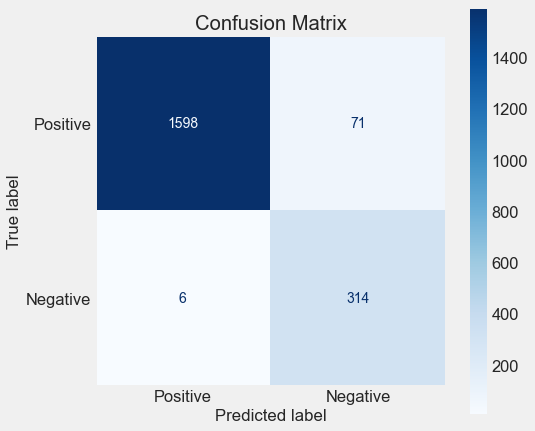

,F1,Recall,Precision
0,0.89078,0.98125,0.815584


In [89]:
fn.confusion_report(tuned_bayes, X_lem_train, y_lem_train)

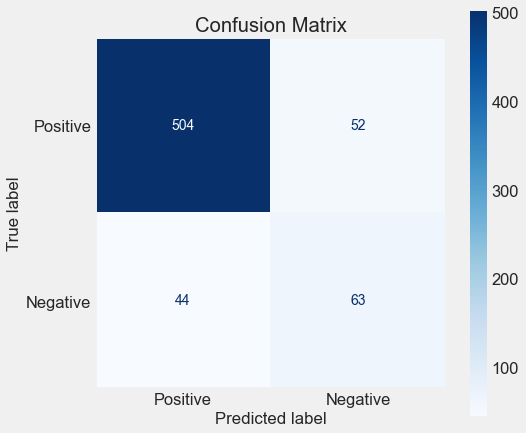

,F1,Recall,Precision
0,0.567568,0.588785,0.547826


In [90]:
fn.confusion_report(tuned_bayes, X_lem_val, y_lem_val)

## Random Forest

In [91]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', RF)]
rf_pipe = Pipeline(steps=steps)
rf_pipe.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=2021))])

In [92]:
modeling.report(rf_pipe, X_lem_train, y_lem_train, 'rf_mo', 'default random forest')

rf_mo has an average F1 of 0.3749997312557945


array([0.40909091, 0.32098765, 0.38202247, 0.3908046 , 0.37209302])

In [93]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
7,rf_mo,0.375000,default random forest
1,baseline smote,0.454602,smote
2,tuned_baseline_smote,0.458612,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
3,tuned_baseline_mo,0.477343,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,baseline_mo,0.479641,minority oversampling
5,multibayes,0.487311,minority oversamp
6,tuned_multibayes,0.491953,"[('tfidf', TfidfVectorizer()), ('oversample', ..."


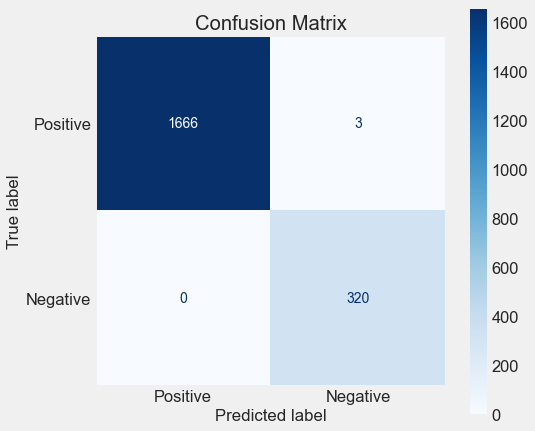

,F1,Recall,Precision
0,0.995334,1.0,0.990712


In [94]:
fn.confusion_report(rf_pipe, X_lem_train, y_lem_train)

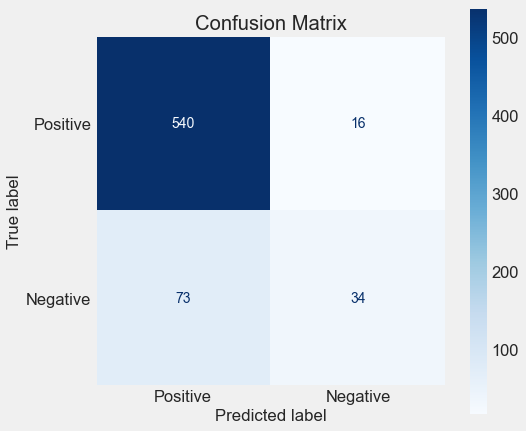

,F1,Recall,Precision
0,0.433121,0.317757,0.68


In [95]:
fn.confusion_report(rf_pipe, X_lem_val, y_lem_val)

## Tuned Random Forest

In [96]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

In [97]:
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': [50, 100],
              'clf__max_depth': [2, 10, None],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [2, 10],
              'clf__max_features': [None, 'auto'],
              'clf__min_samples_leaf': [1, 3]}


In [98]:
# grid_clf = GridSearchCV(rf_pipe, param_grid = parameters,
#                            n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
# grid_clf.fit(X_lem_train, y_lem_train)

In [99]:
# print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
# print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
# print('Best clf__criterion:', grid_clf.best_estimator_.get_params()['clf__criterion'])
# print('Best clf__min_samples_split:', grid_clf.best_estimator_.get_params()['clf__min_samples_split'])
# print('Best clf__max_features:', grid_clf.best_estimator_.get_params()['clf__max_features'])
# print('Best clf__min_samples_leaf:', grid_clf.best_estimator_.get_params()['clf__min_samples_leaf'])

In [100]:
# steps = grid_clf.best_estimator_.get_params()['steps']

In [101]:
saved_steps = [('tfidf', TfidfVectorizer()),
 ('oversample',
  RandomOverSampler(random_state=2021, sampling_strategy='minority')),
 ('clf',
  RandomForestClassifier(max_features=None, min_samples_split=10, n_estimators=50,
                         n_jobs=-1, random_state=2021))]

In [102]:
tuned_rf = Pipeline(steps=saved_steps)
tuned_rf.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 RandomForestClassifier(max_features=None, min_samples_split=10,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=2021))])

In [103]:
modeling.report(tuned_rf, X_lem_train, y_lem_train, 'tuned_rf', f'{steps}')

tuned_rf has an average F1 of 0.4464180709183337


array([0.46774194, 0.42519685, 0.45205479, 0.38709677, 0.5       ])

In [107]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.064977,"tfidf/no ngrams, no sampling"
1,rf_mo,0.375000,default random forest
8,tuned_rf,0.446418,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
2,baseline smote,0.454602,smote
3,tuned_baseline_smote,0.458612,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
4,tuned_baseline_mo,0.477343,"[('tfidf', TfidfVectorizer()), ('oversample', ..."
5,baseline_mo,0.479641,minority oversampling
6,multibayes,0.487311,minority oversamp
7,tuned_multibayes,0.491953,"[('tfidf', TfidfVectorizer()), ('oversample', ..."


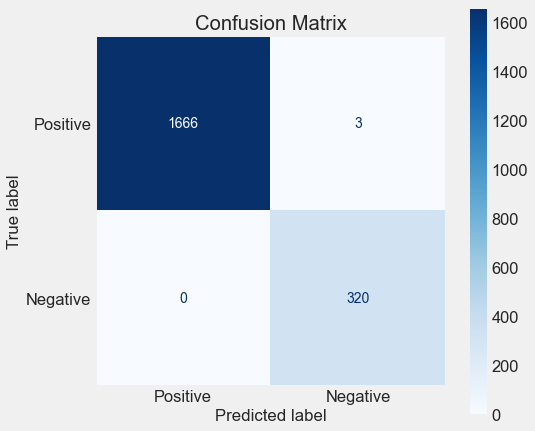

,F1,Recall,Precision
0,0.995334,1.0,0.990712


In [105]:
fn.confusion_report(tuned_rf, X_lem_train, y_lem_train)

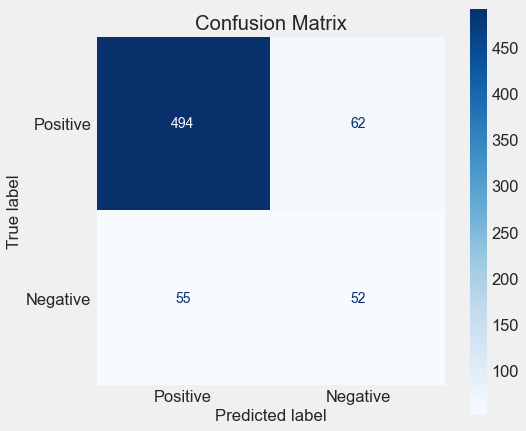

,F1,Recall,Precision
0,0.470588,0.485981,0.45614


In [106]:
fn.confusion_report(tuned_rf, X_lem_val, y_lem_val)